In [64]:
!nvidia-smi

Thu Apr 23 00:53:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    28W /  70W |  11501MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install kaggle

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d greg115/celebrities-100k

 98% 809M/828M [00:15<00:00, 45.3MB/s]
100% 828M/828M [00:15<00:00, 56.2MB/s]


In [0]:
!unzip celebrities-100k.zip

In [0]:
!rm celebrities-100k.zip

In [13]:
!git clone https://github.com/ShivamShrirao/dnn_from_scratch

Cloning into 'dnn_from_scratch'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (325/325), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 1016 (delta 227), reused 187 (delta 94), pack-reused 691
Receiving objects: 100% (1016/1016), 12.97 MiB | 16.23 MiB/s, done.
Resolving deltas: 100% (652/652), done.


In [0]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [0]:
import sys
sys.path.append("/content/dnn_from_scratch")

In [0]:
from matplotlib.image import imread
import cv2

In [0]:
DATA_DIR="/content/100k"
with open(DATA_DIR+".txt","r") as f:
    names=f.read().split('\n')[:-1]

In [0]:
import cupy as cp

In [0]:
from nnet_gpu.network import Sequential
from nnet_gpu.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,conv2dtranspose,upsampling,reshape,BatchNormalization,Activation
from nnet_gpu import functions
from nnet_gpu import optimizers
import numpy as np

In [7]:
def generator():
    model=Sequential()
    model.add(dense(8*8*512,activation=functions.leakyRelu,input_shape=100))
    model.add(reshape((8,8,512)))
    model.add(upsampling())
    model.add(conv2d(512,kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation(functions.leakyRelu))
    model.add(upsampling())
    model.add(conv2d(256,kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation(functions.leakyRelu))
    model.add(upsampling())
    model.add(conv2d(128,kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation(functions.leakyRelu))
    model.add(upsampling())
    model.add(conv2d(64,kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation(functions.leakyRelu))
    model.add(conv2d(3,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
0 dense(dense)            (None, 32768)              leakyRelu        3309568
__________________________________________________________________________________________
1 reshape(reshape)        (None, 8, 8, 512)          echo             0
__________________________________________________________________________________________
2 upsampling(upsampling)  (None, 16, 16, 512)        echo             0
__________________________________________________________________________________________
3 conv2d(conv2d)          (None, 16, 16, 512)        echo             2359808
__________________________________________________________________________________________
4 Ba

In [8]:
def discriminator():
    model=Sequential()
    model.add(conv2d(64,kernel_size=3,stride=[2,2],input_shape=(128,128,3)))
    model.add(Activation(functions.leakyRelu))
    model.add(conv2d(128,kernel_size=3,stride=[2,2]))
    model.add(BatchNormalization())
    model.add(Activation(functions.leakyRelu))
    model.add(conv2d(256,kernel_size=3,stride=[2,2]))
    model.add(BatchNormalization())
    model.add(Activation(functions.leakyRelu))
    model.add(conv2d(512,kernel_size=3,stride=[2,2]))
    model.add(BatchNormalization())
    model.add(Activation(functions.leakyRelu))
    model.add(flatten())
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- input_layer(InputLayer) (None, 128, 128, 3)        echo             0
__________________________________________________________________________________________
0 conv2d(conv2d)          (None, 64, 64, 64)         echo             1792
__________________________________________________________________________________________
1 Activation(Activation)  (None, 64, 64, 64)         leakyRelu        0
__________________________________________________________________________________________
2 conv2d(conv2d)          (None, 32, 32, 128)        echo             73856
__________________________________________________________________________________________
3 BatchNormalization(Batc (None, 32, 32, 128)        echo             512
__________________________________________________________________________________________
4 Activ

In [0]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.0002,beta=0.6)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.0002,beta=0.6)

In [0]:
svdnoise=cp.random.randn(16,100).astype(cp.float32)
gen=g.predict(svdnoise)

In [0]:
def gen_sample():
    noise=cp.random.randn(1,100).astype(cp.float32)
    gen=g.predict(noise)
    plt.imshow((gen[0].get()+1)/2,interpolation='bicubic')
    plt.show()
    print(d.predict(gen)[0])

In [12]:
!mkdir timelapse

mkdir: cannot create directory ‘timelapse’: File exists


In [0]:
def gen_grid(noise,show=True,save=False):
    fig, ax = plt.subplots(nrows=4,ncols=4,figsize=[20,20],gridspec_kw = {'wspace':0, 'hspace':0})
    fig.patch.set_facecolor('white')
    gen=g.predict(noise).get()
    for i,axi in enumerate(ax.flat):
        axi.axis("off")
        axi.imshow((gen[i].squeeze()+1)/2,interpolation='bicubic')
    if save:
        fig.savefig("timelapse/"+str(ccu)+"img"+str(time())[-5:]+".png",bbox_inches='tight')
    if not show:
        plt.close(fig)

In [0]:
ccu=0

In [0]:
batch_size=32

In [0]:
from threading import Thread

In [0]:
transfer_stream=cp.cuda.stream.Stream(non_blocking=True)
default_stream=cp.cuda.get_current_stream()

In [0]:
bch_img=None
event=transfer_stream.record()

In [0]:
def get_batch(st,btsz):
    X_train=[]
    for ii in names[st:st+btsz]:
        img=imread(DATA_DIR+"/100k/"+ii)
#         img=cv2.resize(img, dsize=(64,64), interpolation=cv2.INTER_AREA)
        X_train.append(img/255*2-1)
    global bch_img,event,transfer_stream
    with transfer_stream:
        bch_img=cp.asarray(X_train,dtype=np.float32)
    event=transfer_stream.record(event)

In [0]:
t=Thread(target=get_batch,args=(ccu,batch_size,))
t.setDaemon(True)
t.start()

In [0]:
def run(batch_size=16):
    global ccu,svdnoise
    dsz=len(names)
    # Label real ones as 90% real
    y_fake=cp.zeros((batch_size,1),dtype=cp.float32)
    y_real=cp.ones((batch_size,1),dtype=cp.float32)
    y_gen=cp.ones((batch_size,1),dtype=cp.float32)
    for step in range(dsz//batch_size):
        # Get random real images
        global bch_img,event,default_stream,t
        t.join()
        default_stream.wait_event(event)
        real_images=bch_img
        t=Thread(target=get_batch,args=(ccu,batch_size,))
        t.setDaemon(True)
        t.start()
        if len(real_images)!=batch_size:
          continue
        ccu+=batch_size
        if ccu>len(names):
            ccu=0
            break
        stt=time()
        noise=cp.random.randn(batch_size,100,dtype=cp.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Train discriminator
        y_fake=cp.random.uniform(0,0.05,(batch_size,1),dtype=cp.float32)
        y_real=cp.random.uniform(0.95,1,(batch_size,1),dtype=cp.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
        noise=cp.random.randn(batch_size,100,dtype=cp.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        # backpropogate the generator and update weights
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        stptm=time()-stt
        if not step%120 and step>0:
            print("\nSaving grid.")
            gen_grid(svdnoise[:25],show=False,save=True)
            gen_sample()
        global transfer_stream
        with transfer_stream:
            print(f"\rProgress: {step*batch_size*100/dsz:.2f} %    {ccu}    Dloss: {dloss.get(transfer_stream)}    err: {abs(err).sum().get(transfer_stream)}    Step time: {stptm:.3f}s    _",end='')
    if ccu>len(names):
        ccu=0

In [0]:
import gc

In [0]:
gc.collect()
cp.get_default_pinned_memory_pool().free_all_blocks()
cp.get_default_memory_pool().free_all_blocks()

In [0]:
epochs=10
for epoch in range(epochs):
    gc.collect()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    cp.get_default_memory_pool().free_all_blocks()
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run(batch_size)
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))

EPOCH: 1 / 10
Progress: 0.93 %    22560    Dloss: 156.9156494140625    err: 730930.75    Step time: 1.175s    _

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

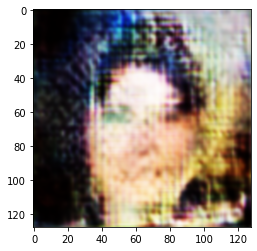

[0.52908874]


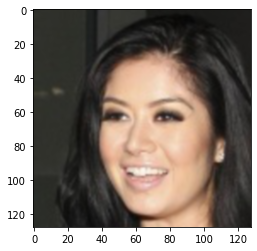

[[0.39137557]]


In [37]:
noise=cp.random.randn(16,100).astype(cp.float32)
gen=g.predict(noise)
gen_sample()
imdt=[]
st=np.random.randint(low=0,high=len(names))
for ii in names[st:st+1]:
    img=imread(DATA_DIR+"/100k/"+ii)
#         img=cv2.resize(img, dsize=(64,64), interpolation=cv2.INTER_AREA)
    imdt.append(img/255*2-1)
img=cp.asarray(imdt)
plt.imshow((img[0].get()+1)/2,interpolation='bicubic')
plt.show()
print(d.predict(img))

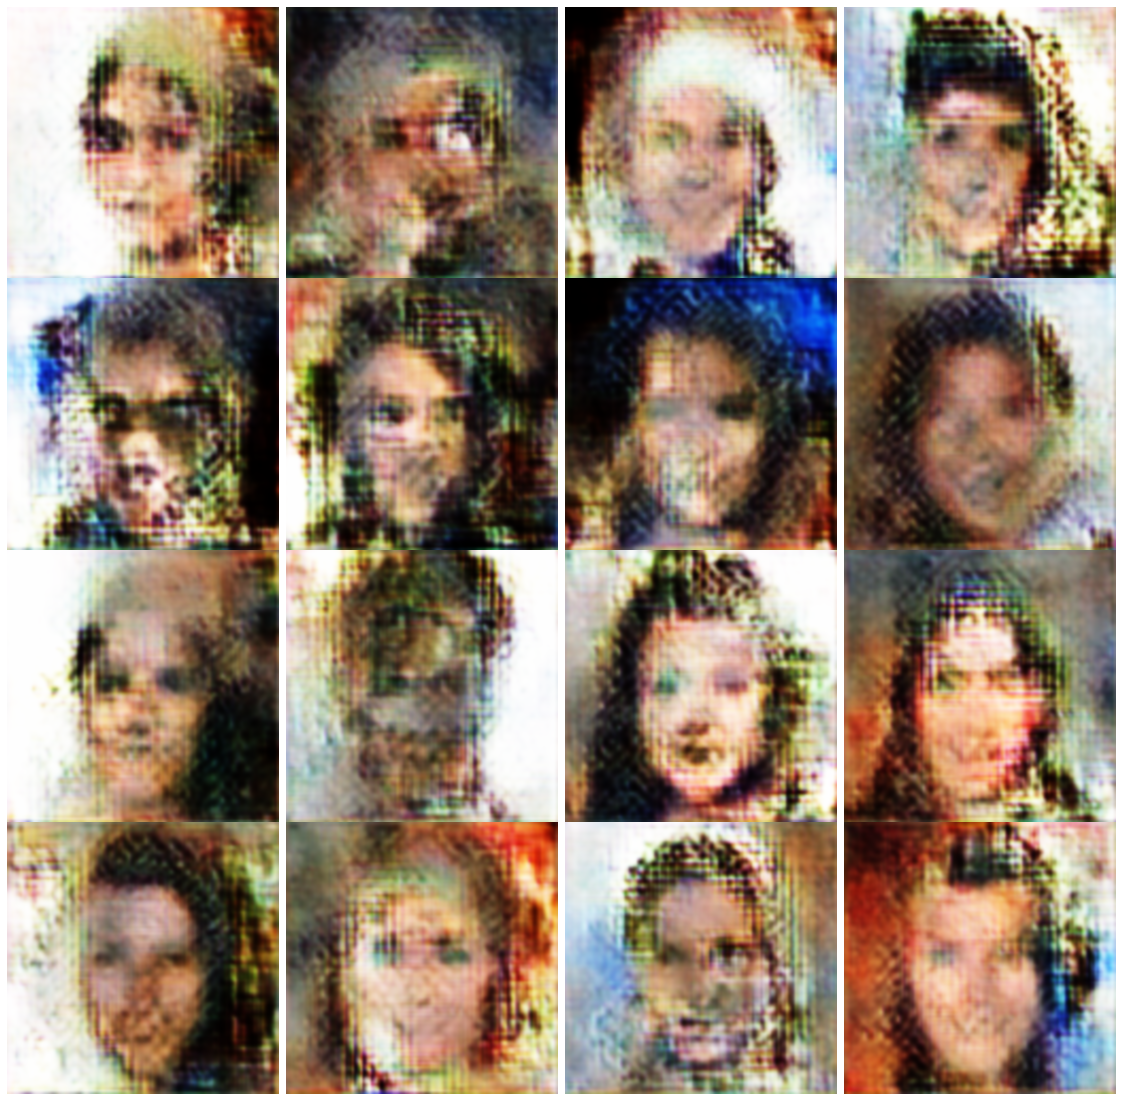

In [36]:
noise=cp.random.randn(16,100).astype(cp.float32)
gen_grid(noise)

In [0]:
# g.load_weights("generator.w8s")
# d.load_weights("discriminator.w8s")

In [0]:
g.save_weights("generator.w8s")
d.save_weights("discriminator.w8s")

[!] Load and save is bugged. You can use it for saving,loading and prediction but training further from loaded weights isn't working.
[!] Load and save is bugged. You can use it for saving,loading and prediction but training further from loaded weights isn't working.
